In [ ]:
# generic imports
from typing import List, Tuple, Optional, Literal
from dataclasses import dataclass
import os
import itertools
import json 
from pprint import pprint

# task specific imports
import numpy as np
import cv2
%matplotlib widget
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# project imports
from CourtModule import CanonicalCourt2D, CanonicalCourt3D
from CalibrationModule import *
from TrackingModule import BallTracker
from TrajectoryModule import TrajectoryEstimator


# Path
CALIBRATION_IMG = "C:/Documents/Polimi/IACV/ProjectAssignment/Project/data/calibration/court_frontal.png"
assert os.path.exists(CALIBRATION_IMG)
METADATA = "C:/Documents/Polimi/IACV/ProjectAssignment/Project/data/calibration/metadata.json"
assert os.path.exists(METADATA)
VIDEO = "C:/Documents/Polimi/IACV/ProjectAssignment/Project/data/raw/video.MP4"
assert os.path.exists(VIDEO)

# Global Vars
DEBUG = True
RESET_METADATA = True


In [23]:
# 2. Overwrite the destination file with the new data
# Opening with 'w' mode automatically wipes the existing file content
if RESET_METADATA:
    new_data = {"calibration": {},
                "camera_params": {},
                "coordinate_system": {
                    "origin": "Hoop center projection on the ground",
                    "axes": {
                            "X": "Right->left",
                            "Y": "hoop->camera",
                            "Z": "ground->up"
                    },
                    "units": "meters",
                    "note": "ground is Z=0"
                    }
                }
    with open(METADATA, 'w') as destination_file:
        json.dump(new_data, destination_file, indent=4)

In [24]:
# Initialize Calibration Display
CDisp = CalibrationDisplay(CALIBRATION_IMG)
Court3D = CanonicalCourt3D()
Court2D = CanonicalCourt2D()

print(f"Pixel Shape: (h:{CDisp.h_raw}) by (w:{CDisp.w_raw})\nScale factor of: {CDisp.scale}\nWhen calibrating click points in correct order")


Pixel Shape: (h:1608) by (w:2868)
Scale factor of: 0.4881450488145049
When calibrating click points in correct order


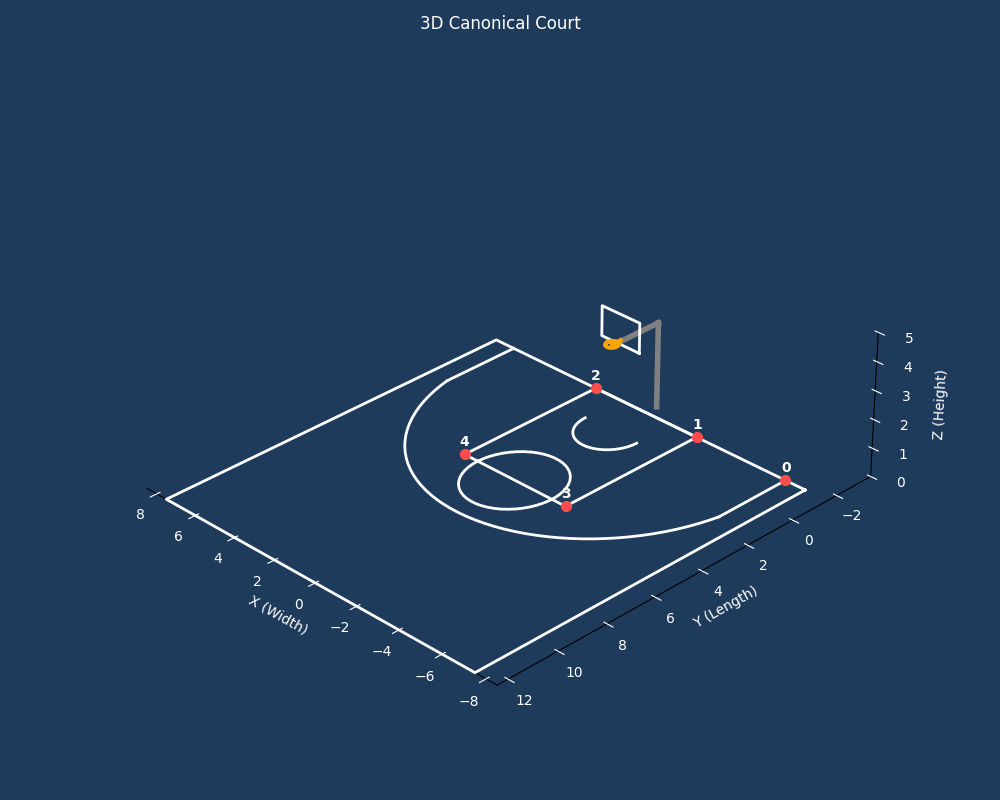

Press 'q' to quit drawing mode and 'u' to undo last action.
Point: (1334, 561)
Point: (921, 553)
Point: (436, 547)
Point: (1092, 662)
Point: (270, 654)
Resizing to original pixel dimensions...


In [25]:

# Calibration Module

img_2d, real_3d = get_calibration_points(CDisp, recover_from_file=False, 
                                         metadata_file=METADATA, 
                                         save_to_file=True,
                                         court2D=Court3D)

real_3d = np.array(real_3d)
img_2d = np.array(img_2d)


In [26]:
print("Real 3D Point Coordinates:")
print(real_3d)
print("Equivalent 2D Image Pixel Coordinates")
print(img_2d)


Real 3D Point Coordinates:
[[       -6.6      -1.575           0]
 [      -2.45      -1.575           0]
 [       2.45      -1.575           0]
 [      -2.45       4.225           0]
 [       2.45       4.225           0]]
Equivalent 2D Image Pixel Coordinates
[[     2732.8      1149.2]
 [     1886.7      1132.9]
 [     893.18      1120.6]
 [       2237      1356.2]
 [     553.11      1339.8]]


In [27]:
# Calibration 
calibration_results = calibrate_camera_pnp(img_pts=img_2d, real_pts=real_3d, 
                                           h=CDisp.h_raw, w=CDisp.w_raw, 
                                           metadata_file=METADATA, 
                                           camera_height_threshold=(0.5, 5.0))

indexes_z0 = [i for i, item in enumerate(real_3d) if item[2] == 0]

H, inliers = get_z_plane_homography([img_2d[i] for i in indexes_z0], 
                                    [real_3d[i] for i in indexes_z0], 
                                    metadata_file=METADATA, 
                                    save_to_file=True)

intrinsic_matrix = np.array(calibration_results["intrinsic_matrix"])
rotation_matrix = np.array(calibration_results["rotation_matrix"])
translation_vector = np.array(calibration_results["translation_vector"])
focal_length = calibration_results["focal_length"]
camera_height = calibration_results["camera_height"]


tvec = [[   -0.17353]
 [     1.5867]
 [     12.715]]
Camera center (world calib) = [[   0.065396]
 [     12.717]
 [      1.575]]
R[2,:] (camera Z axis in world) = [  -0.016875    -0.99986   0.0011104]
Refined Focal Length: 2917.664755622804
Camera Height above court: 1.5750135895237236 units (Meters -> court units are in meters)


In [59]:

# camera model

camera = CameraModel(K=intrinsic_matrix, 
                     R=rotation_matrix, 
                     t=translation_vector)

fps = camera.get_fps(VIDEO) # Method also automatically sets fps variable inside camera model
camera.summary()


Camera Model Summary
--------------------
Intrinsics K:
 [[     2917.7           0        1434]
 [          0      2917.7         804]
 [          0           0           1]]

Rotation R:
 [[   -0.99974     0.01689    0.015307]
 [  -0.015323  -0.0008518    -0.99988]
 [  -0.016875    -0.99986   0.0011104]]

Translation t:
 [   -0.17353      1.5867      12.715]

Camera center C (world):
 [   0.065396      12.717       1.575]



[DEBUG] Checking court reprojection...


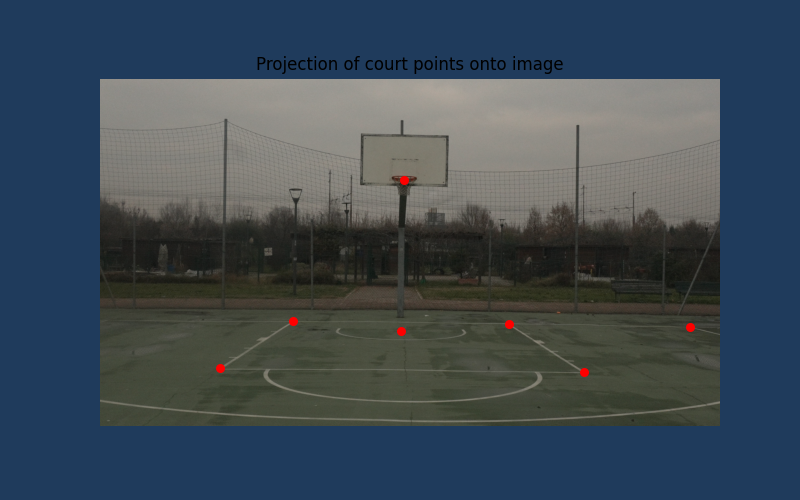


[DEBUG] Checking ground point depths...
Point [       -6.6      -1.575           0] has depth 14.4008
Point [      -2.45      -1.575           0] has depth 14.3308
Point [       2.45      -1.575           0] has depth 14.2481
Point [      -2.45       4.225           0] has depth 8.5316
Point [       2.45       4.225           0] has depth 8.4489

[DEBUG] Checking backprojection on ground plane...
Backprojected ground point: [     2.4487     -1.6173           0]

Calibration debugger: all checks completed. Validate the results...


In [29]:

# debugging tool

debugger = CalibrationDebugger(camera=camera,   # sets debugger for usage going forward
                               court_2d=CanonicalCourt2D, 
                               image_path=CALIBRATION_IMG)

# --- Debug Checks ---
print("\n[DEBUG] Checking court reprojection...")
debugger.check_in_court_projection(object_pts_3d=real_3d.tolist()+[[0,0,0],[0,0,3.05]])

print("\n[DEBUG] Checking ground point depths...")
debugger.check_ground_point_depth(object_pts_3d=real_3d)

print("\n[DEBUG] Checking backprojection on ground plane...")
u_test, v_test = img_2d[2]  # Free-throw center
debugger.check_backprojection_on_ground(u_test, v_test)

print("\nCalibration debugger: all checks completed. Validate the results...")
# --- Checks Completed ---


In [60]:

# Tracking Module
calibration_resolution=(CDisp.h_raw, CDisp.w_raw)

tracker = BallTracker(mode='simple')
tracks = tracker.track_video(video_path=VIDEO, 
                             calibration_resolution=calibration_resolution, 
                             save_to_metadata=True,
                             visualize=True)
s_u, s_v = tracker.get_ball_uv_start(video_path=VIDEO, 
                                    calibration_resolution=calibration_resolution,
                                    visualize=True)
s_x, s_y = camera.project_pixel_to_ground(s_u, s_v)



[TRACKER DIAGNOSTIC]
Real video Resolution: 3840x2160
Calibration Resolution Given: 2868x1608
Mismatch Detected! Aplying Scaling factor: X=0.747, Y=0.744
Carregando YOLOv8-Pose...
Detectando jogador...

PÉ ESQUERDO (YOLO): (790, 1523)
PÉ DIREITO (YOLO):  (792, 1532)
------------------------------
CENTRO DOS PÉS:     (791, 1527)


[TRACKER DIAGNOSTIC]
Real video Resolution: 3840x2160
Calibration Resolution Given: 2868x1608
Mismatch Detected! Aplying Scaling factor: X=0.747, Y=0.744


In [14]:
with open(METADATA, 'r') as metadata:
    data = json.load(metadata)
    tracks = data["tracking"]
    cam_data = data["camera_params"]["calibration_pnp"]
    camera = CameraModel(K=np.array(cam_data["intrinsic_matrix"]), 
                         R=np.array(cam_data["rotation_matrix"]), 
                         t=np.array(cam_data["translation_vector"]))
    camera.get_fps(VIDEO)
    tracker = BallTracker(mode='simple', metadata_path=METADATA)
    CDisp = CalibrationDisplay(CALIBRATION_IMG)
    calibration_resolution=(CDisp.h_raw, CDisp.w_raw)
    s_u, s_v = tracker.get_ball_uv_start(video_path=VIDEO, 
                                            calibration_resolution=calibration_resolution)
    s_x, s_y = camera.project_pixel_to_ground(s_u, s_v)
    Court3D = CanonicalCourt3D()

KeyError: 'tracking'

In [61]:

# Trajectory Module

estimator = TrajectoryEstimator(court_model=Court3D,
                                camera_model=camera)

results = estimator.multi_segment_reconstruct(tracks, 
                                              proximity_threshold=75,
                                              shooter_ground_pos=(s_x, s_y))

nested_list = []

for segment in results:

    nested_list.append(estimator.generate_3d_points_from_result(result_entry=segment,
                                                                    step_t=0.033,  # defines granularity of 3d trajectory plot
                                                                    output_json = "ResultTrajectory3D.json"))

trajectory3D = list(itertools.chain.from_iterable(nested_list)) # to flatten nested list


>> Usando âncora dos pés: X=3.69, Y=-0.77
Bounce detectado no frame 114.
Distância do quique ao aro: 42.45 pixels
>> Bounce Type: Rim (Z=3.05)


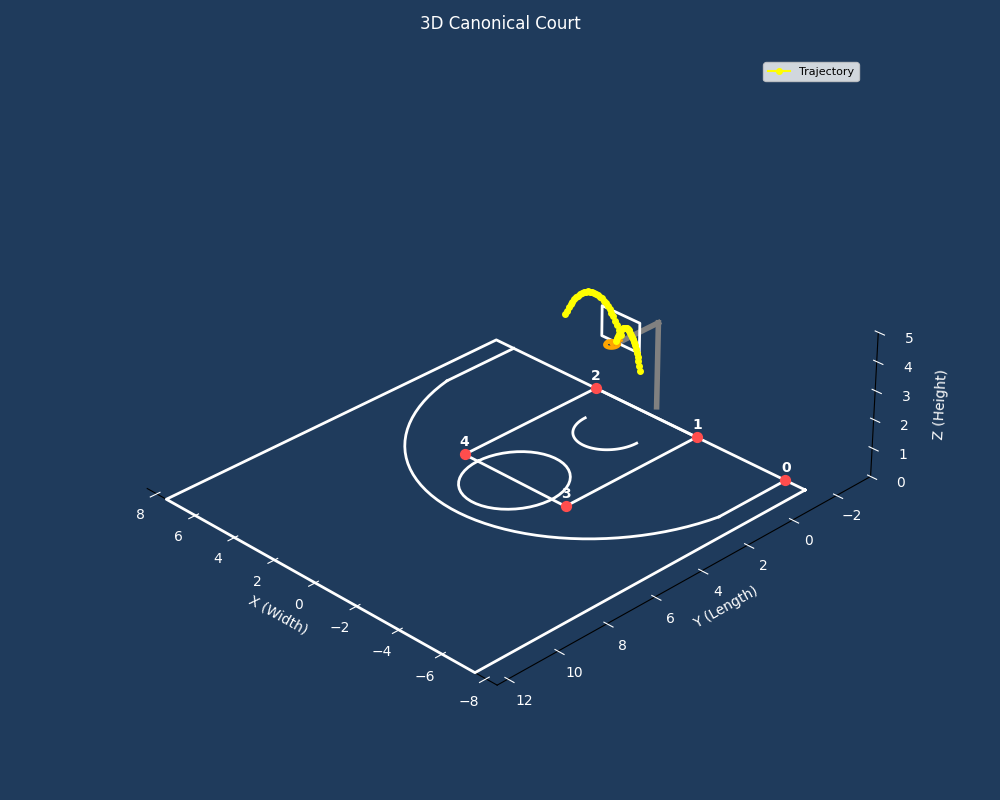

In [62]:
# Plot Trajectory on 3D Court

Court3D.plot_court(add_trajectory=True,
                   trajectory_points=trajectory3D)



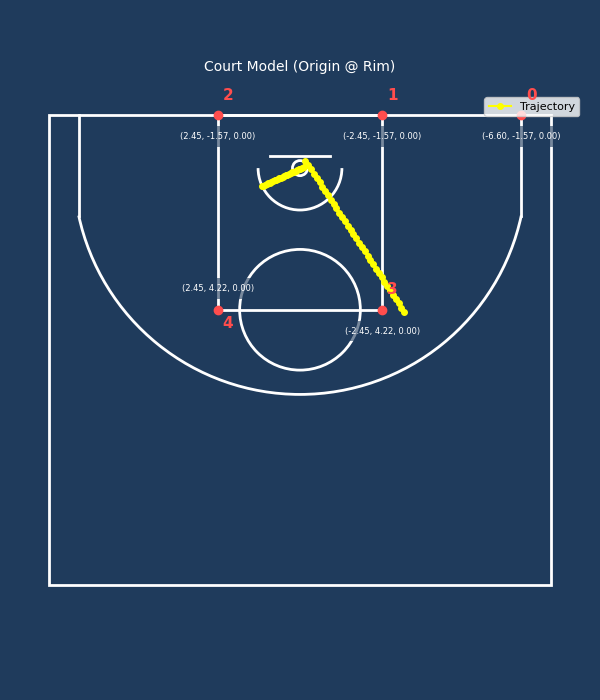

In [17]:
Court2D.plot_court(add_trajectory=True,
                   trajectory_points=trajectory3D)

In [15]:
with open (METADATA, 'r') as f:
    metadata = json.load(f)
    pprint(metadata)

{'HomographyZ': [[0.0020572631553965135,
                  -0.00010183223149694893,
                  -2.753735054757667],
                 [0.00021094635485393505,
                  -0.016425423169690454,
                  18.88854161144726],
                 [2.2245830703194124e-05, -0.001286585896586702, 1.0]],
 'calibration': {'points_2d': [[2726.6485714285714, 1147.2],
                               [1886.7342857142858, 1130.8114285714287],
                               [889.08, 1122.6171428571429],
                               [2239.0885714285714, 1358.202857142857],
                               [555.1628571428571, 1339.7657142857142]],
                 'points_3d': [[-6.6, -1.575, 0],
                               [-2.45, -1.575, 0],
                               [2.45, -1.575, 0],
                               [-2.45, 4.225, 0],
                               [2.45, 4.225, 0]]},
 'camera_params': {'calibration_pnp': {'camera_height': 1.5849343250108596,
                